In [28]:
import pandas as pd
import json


In [26]:
df = pd.read_csv("../data/Entire/HKUST_All_Buildings.csv")

In [27]:
df.head(20)

,time,number,metric_id,building_name
0,2022-01-01 00:00:00.000,8776730.0,D0601,Academic_Building
1,2022-01-02 00:00:00.000,8784160.0,D0601,Academic_Building
2,2022-01-03 00:00:00.000,8792140.0,D0601,Academic_Building
3,2022-01-04 00:00:00.000,8794370.0,D0601,Academic_Building
4,2022-01-05 00:00:00.000,8796700.0,D0601,Academic_Building
5,2022-01-06 00:00:00.000,8798960.0,D0601,Academic_Building
6,2022-01-07 00:00:00.000,8801750.0,D0601,Academic_Building
7,2022-01-08 00:00:00.000,8803590.0,D0601,Academic_Building
8,2022-01-09 00:00:00.000,8805060.0,D0601,Academic_Building
9,2022-01-10 00:00:00.000,8813950.0,D0601,Academic_Building


In [29]:
# Group metrics by building
building_metrics = (
    df.groupby("building_name")["metric_id"]
      .unique()                 # keep only unique metric IDs
      .apply(list)              # convert numpy arrays to Python lists
      .to_dict()                # convert to dictionary
)

# Save as JSON
with open("building_metrics.json", "w", encoding="utf-8") as f:
    json.dump(building_metrics, f, indent=4, ensure_ascii=False)

print("✅ JSON file 'building_metrics.json' created successfully!")

✅ JSON file 'building_metrics.json' created successfully!


In [33]:
import os
import glob
import json
import pandas as pd

# === chemins à adapter si besoin ===
T60_DIR = "T1440"
JSON_PATH = "building_metrics.json"
OUTPUT_CSV = "T1440_merged.csv"

# 1) Charger le JSON: building_name -> [metric_id]
with open(JSON_PATH, "r", encoding="utf-8") as f:
    building_metrics = json.load(f)

# 2) Inverser le mapping: metric_id -> building_name
metric_to_building = {}
for building, metrics in building_metrics.items():
    for m in metrics:
        metric_to_building[m] = building

# 3) Parcourir tous les fichiers XLSX du dossier T60
all_dfs = []

for path in glob.glob(os.path.join(T60_DIR, "*.xlsx")):
    filename = os.path.basename(path)          # ex: GUI_NO.D0601.xlsx

    # 4) Extraire le metric/device_id depuis le nom du fichier
    #    GUI_NO.D0601.xlsx -> ["GUI_NO", "D0601", "xlsx"] -> "D0601"
    parts = filename.split(".")
    if len(parts) < 3:
        print(f"[WARN] Nom de fichier inattendu : {filename}, ignoré.")
        continue

    device_id = parts[1]                       # D0601
    building = metric_to_building.get(device_id, "UNKNOWN")

    # 5) Lire le fichier Excel
    df = pd.read_excel(path)

    # On s'assure que les colonnes existent
    if not {"time", "number"}.issubset(df.columns):
        print(f"[WARN] Colonnes manquantes dans {filename}, ignoré.")
        continue

    # Ajouter device_id et building
    df["device_id"] = device_id
    df["building"] = building

    # Garder juste les colonnes dans l'ordre voulu
    df = df[["time", "number", "device_id", "building"]]

    all_dfs.append(df)

# 6) Concaténer et sauvegarder en CSV
if all_dfs:
    merged = pd.concat(all_dfs, ignore_index=True)
    merged.to_csv(OUTPUT_CSV, index=False)
    print(f"✅ Fichier CSV créé : {OUTPUT_CSV}")
    print(merged.head())
else:
    print("❌ Aucun fichier valide trouvé dans le dossier T60.")

✅ Fichier CSV créé : T1440_merged.csv
        time     number device_id           building
0 2022-01-01  9254520.0     D0816  Academic_Building
1 2022-01-02  9256540.0     D0816  Academic_Building
2 2022-01-03  9258550.0     D0816  Academic_Building
3 2022-01-04  9260790.0     D0816  Academic_Building
4 2022-01-05  9263080.0     D0816  Academic_Building


In [5]:
# Compter les NaN pour chaque colonne
nan_counts = df.isna().sum().sort_values(ascending=False)

print("Nombre de valeurs manquantes par colonne :")
print(nan_counts)

Nombre de valeurs manquantes par colonne :
time         0
number       0
metric_id    0
dtype: int64


In [6]:
df_academic = df.copy()

In [7]:
df_academic['time'] = pd.to_datetime(df_academic['time'], format='mixed', errors='coerce')

In [8]:
print("Min time:", df_academic["time"].min())
print("Max time:", df_academic["time"].max())

Min time: 1970-01-01 08:00:00
Max time: 2024-05-27 23:59:54


In [9]:
df_academic['year'] = df_academic['time'].dt.year
df_academic['month'] = df_academic['time'].dt.month
df_academic['day'] = df_academic['time'].dt.day
df_academic['hh_mm_ss'] = df_academic['time'].dt.time

# Réorganiser les colonnes dans l'ordre souhaité
df_academic = df_academic[['metric_id', 'number', 'year', 'month', 'day', 'hh_mm_ss', 'time']]

# Afficher les premières lignes pour vérifier
print(df_academic.head(10))
print(f"\nShape: {df_academic.shape}")



  metric_id     number  year  month  day  hh_mm_ss       time
0     D0601  8776730.0  2022      1    1  00:00:00 2022-01-01
1     D0601  8784160.0  2022      1    2  00:00:00 2022-01-02
2     D0601  8792140.0  2022      1    3  00:00:00 2022-01-03
3     D0601  8794370.0  2022      1    4  00:00:00 2022-01-04
4     D0601  8796700.0  2022      1    5  00:00:00 2022-01-05
5     D0601  8798960.0  2022      1    6  00:00:00 2022-01-06
6     D0601  8801750.0  2022      1    7  00:00:00 2022-01-07
7     D0601  8803590.0  2022      1    8  00:00:00 2022-01-08
8     D0601  8805060.0  2022      1    9  00:00:00 2022-01-09
9     D0601  8813950.0  2022      1   10  00:00:00 2022-01-10

Shape: (19987163, 7)


In [10]:
# 🧩 Extraire les lignes non valides pour datetime
mask_valid = df_academic[["year", "month", "day", "hh_mm_ss"]].notna().all(axis=1)
invalid_rows = df_academic.loc[~mask_valid]

print(f"Nombre de lignes non valides : {len(invalid_rows):,}")

# Aperçu des premières lignes problématiques
display(invalid_rows.head(10))

# Si tu veux savoir quelle colonne pose problème :
missing_summary = df_academic[["year", "month", "day", "hh_mm_ss"]].isna().sum()
print("\nRésumé des colonnes manquantes :")
print(missing_summary)


Nombre de lignes non valides : 0


,metric_id,number,year,month,day,hh_mm_ss,time



Résumé des colonnes manquantes :
year        0
month       0
day         0
hh_mm_ss    0
dtype: int64


Academic_Building

In [11]:
import pandas as pd

# 1️⃣ Garder seulement les lignes où year, month, day, hh_mm_ss sont non nuls
mask_valid = df_academic[["year", "month", "day", "hh_mm_ss"]].notna().all(axis=1)
tmp = df_academic.loc[mask_valid].copy()

print(f"Lignes totales : {len(df_academic)}")
print(f"Lignes valides pour datetime : {len(tmp)}")

# 2️⃣ Convertir year/month/day en int proprement
for col in ["year", "month", "day"]:
    tmp[col] = tmp[col].astype(float).round().astype("Int64")  # gestion des floats + NaN
    tmp[col] = tmp[col].astype(int)  # maintenant sûr, plus de NaN

# 3️⃣ Reconstruire une colonne datetime
tmp["datetime"] = pd.to_datetime(
    tmp["year"].astype(str) + "-" +
    tmp["month"].astype(str).str.zfill(2) + "-" +
    tmp["day"].astype(str).str.zfill(2) + " " +
    tmp["hh_mm_ss"].astype(str),
    errors="coerce"
)

# 4️⃣ Plage temporelle
start_date = tmp["datetime"].min()
end_date   = tmp["datetime"].max()
duration   = end_date - start_date

print("\n📅 Période couverte par Academic_Building :")
print(f"  → Début : {start_date}")
print(f"  → Fin   : {end_date}")
print(f"  → Durée totale : {duration.days:,} jours ≈ {duration.days/365:.2f} ans")


Lignes totales : 19987163
Lignes valides pour datetime : 19987163

📅 Période couverte par Academic_Building :
  → Début : 1970-01-01 08:00:00
  → Fin   : 2024-05-27 23:59:54
  → Durée totale : 19,870 jours ≈ 54.44 ans


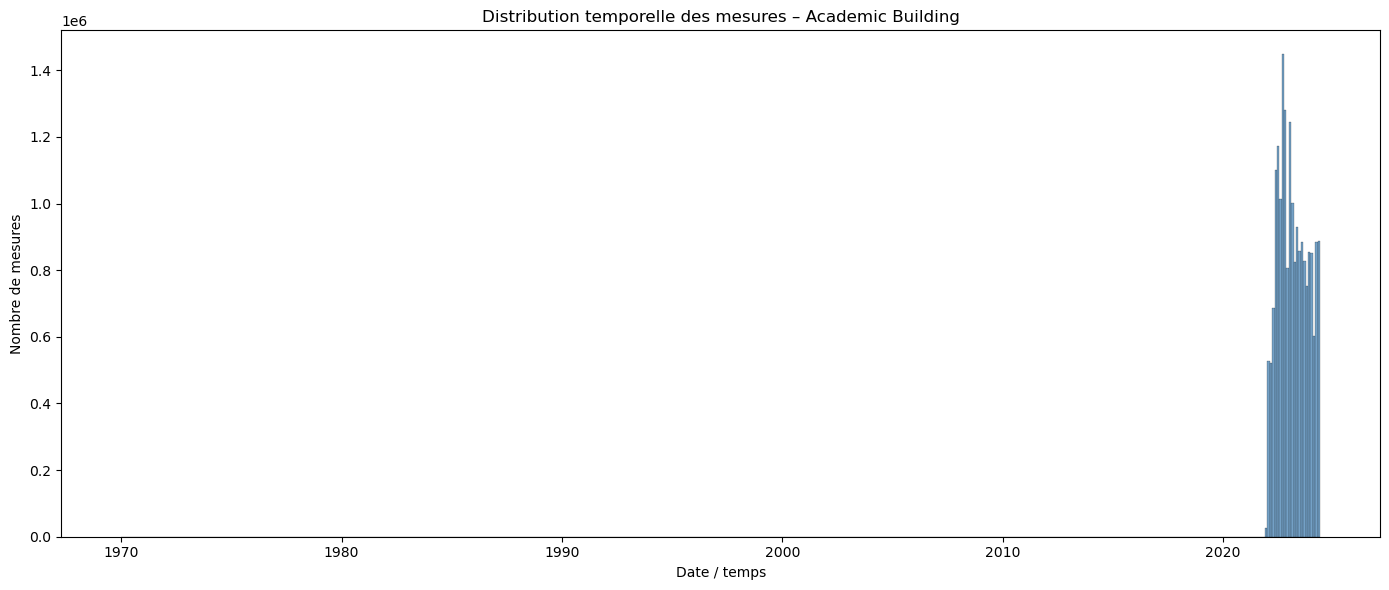

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14,6))
sns.histplot(df_academic["time"], bins=500, color="steelblue")
plt.title("Distribution temporelle des mesures – Academic Building")
plt.xlabel("Date / temps")
plt.ylabel("Nombre de mesures")
plt.tight_layout()
plt.show()

In [13]:
df_academic = df_academic[df_academic["time"] >= "2022-01-01"].copy()

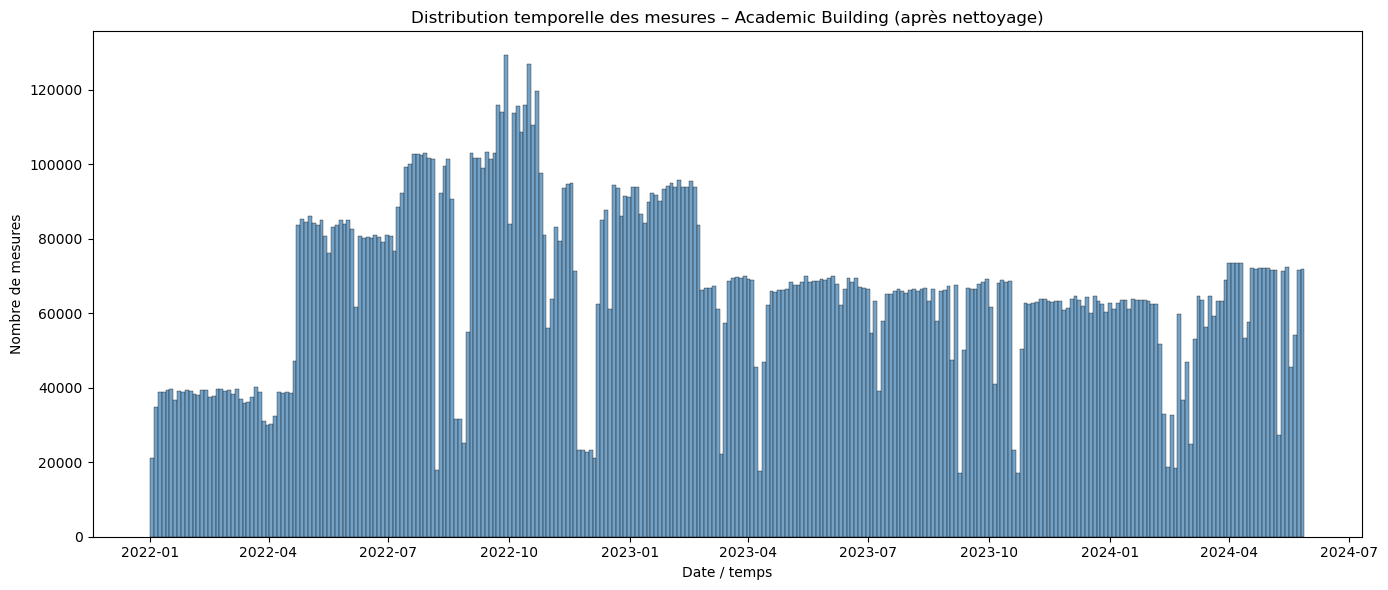

In [47]:
plt.figure(figsize=(14,6))
sns.histplot(df_academic["time"], bins=300, color="steelblue")
plt.title("Distribution temporelle des mesures – Academic Building (après nettoyage)")
plt.xlabel("Date / temps")
plt.ylabel("Nombre de mesures")
plt.tight_layout()
plt.show()

  metric_id  count
0     D0601  16694
1     D0602  16692
2     D0603  16688
3     D0604  16687
4     D0606  16707
5     D0607  16710
6     D0608   9754
7     D0609  16706
8     D0610  16706
9     D0611   9752
Index(['metric_id', 'count'], dtype='object')


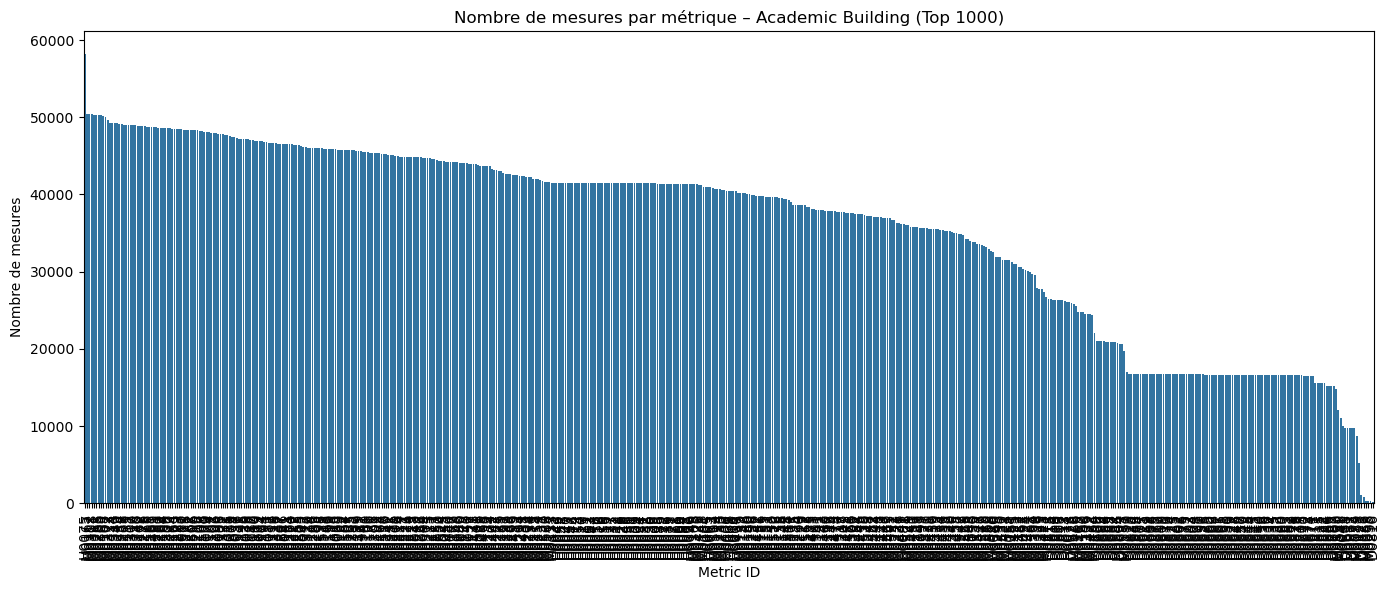

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Compter le nombre de mesures par metric_id
metric_counts = (
    df_academic
    .groupby("metric_id", as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

print(metric_counts.head(10))
print(metric_counts.columns)

# 2️⃣ (optionnel) trier et garder les 30 métriques les plus fournies
metric_counts = metric_counts.sort_values("count", ascending=False)
top_n = 1000
metric_counts_top = metric_counts.head(top_n)

# 3️⃣ Barplot
plt.figure(figsize=(14, 6))
sns.barplot(data=metric_counts_top, x="metric_id", y="count")
plt.title(f"Nombre de mesures par métrique – Academic Building (Top {top_n})")
plt.xlabel("Metric ID")
plt.ylabel("Nombre de mesures")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [15]:
# 1️⃣ Recalculer le nombre de mesures par metric_id
metric_counts = (
    df_academic.groupby("metric_id", as_index=False)
    .size()
    .rename(columns={"size": "count"})
)

# 2️⃣ Identifier les métriques à garder
valid_metrics = metric_counts[metric_counts["count"] >= 10000]["metric_id"]

# 3️⃣ Filtrer le DataFrame principal
df_academic = df_academic[df_academic["metric_id"].isin(valid_metrics)].copy()

print(f"✅ Nombre de métriques conservées : {len(valid_metrics)}")
print(f"✅ Nombre total de lignes après filtrage : {len(df_academic):,}")

✅ Nombre de métriques conservées : 547
✅ Nombre total de lignes après filtrage : 19,911,719


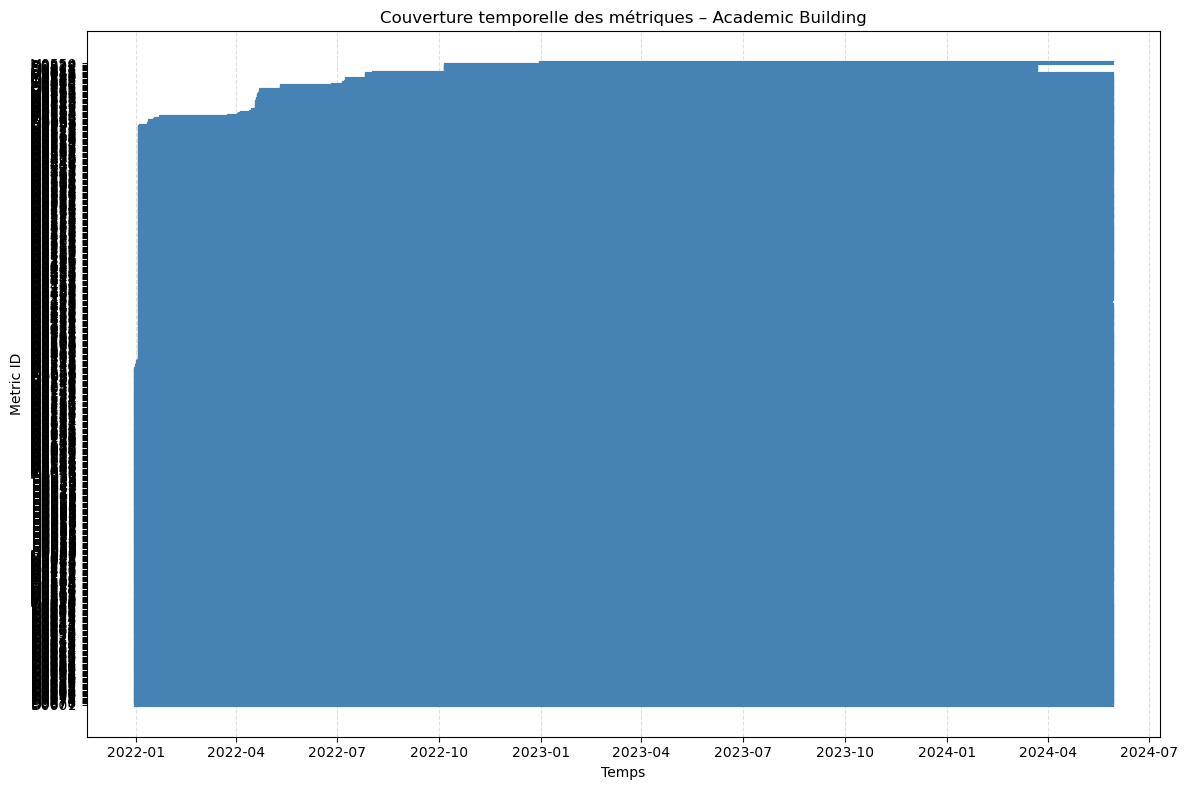

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1️⃣ Calculer la plage temporelle par metric_id
metric_range = (
    df_academic.groupby("metric_id")["time"]
    .agg(["min", "max"])
    .reset_index()
    .sort_values("min")
)

# 2️⃣ Créer une figure (timeline)
plt.figure(figsize=(12, 8))
for i, row in metric_range.iterrows():
    plt.plot([row["min"], row["max"]], [row["metric_id"], row["metric_id"]],
             color="steelblue", linewidth=3)

plt.title("Couverture temporelle des métriques – Academic Building")
plt.xlabel("Temps")
plt.ylabel("Metric ID")
plt.grid(True, axis="x", linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


📊 Stats globales sur les intervalles (en secondes) :
count    1.991117e+07
mean     1.994752e+03
std      1.856332e+04
min      0.000000e+00
25%      1.573000e+03
50%      1.801000e+03
75%      1.809000e+03
max      2.603016e+07
Name: delta_s, dtype: float64

🔝 Intervalles les plus fréquents (en secondes) :
delta_s
1801.0    5690180
1800.0    1867661
4.0       1135683
3600.0    1110761
1810.0    1005946
5.0        920781
0.0        589656
1805.0     562018
1809.0     497052
9.0        370618
Name: count, dtype: int64


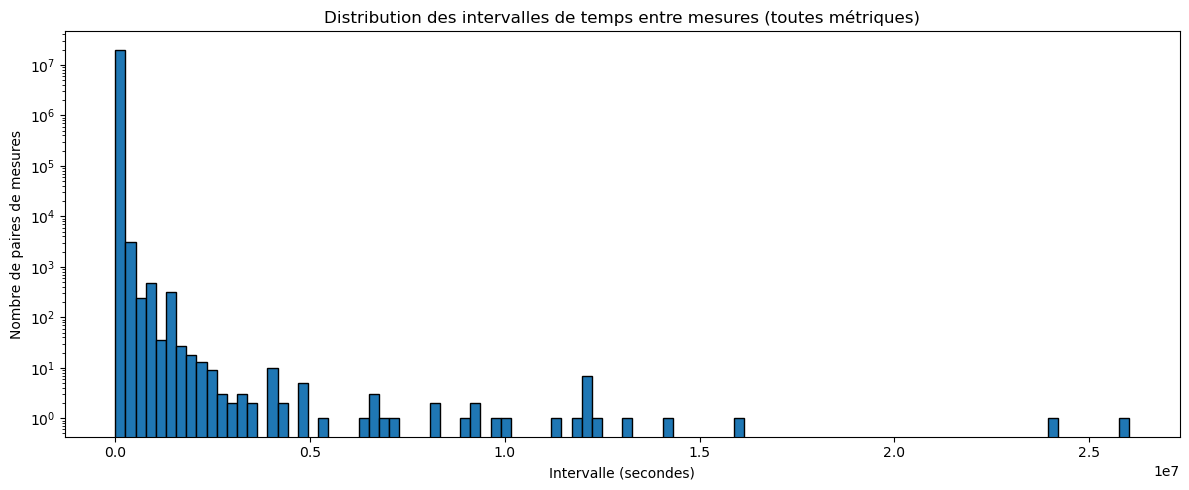

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# 1️⃣ S'assurer que les données sont triées par metric_id + time
df_academic = df_academic.sort_values(["metric_id", "time"]).copy()

# 2️⃣ Calculer l'intervalle de temps entre deux mesures consécutives (en secondes)
df_academic["delta_s"] = (
    df_academic
    .groupby("metric_id")["time"]
    .diff()
    .dt.total_seconds()
)

# On enlève les premières lignes de chaque metric (delta = NaN)
delta = df_academic["delta_s"].dropna()

# 3️⃣ Quelques stats de base
print("📊 Stats globales sur les intervalles (en secondes) :")
print(delta.describe())

print("\n🔝 Intervalles les plus fréquents (en secondes) :")
print(delta.value_counts().head(10))

# 4️⃣ Histogramme de la distribution des intervalles
plt.figure(figsize=(12, 5))
plt.hist(delta, bins=100, edgecolor="black")
plt.title("Distribution des intervalles de temps entre mesures (toutes métriques)")
plt.xlabel("Intervalle (secondes)")
plt.ylabel("Nombre de paires de mesures")
plt.yscale("log")  # utile si gros écart de fréquences
plt.tight_layout()
plt.show()


In [22]:
df_academic.head(100)

,metric_id,number,year,month,day,hh_mm_ss,time,delta_s
0,D0601,8776730.0,2022,1,1,00:00:00,2022-01-01,NaN
1,D0601,8784160.0,2022,1,2,00:00:00,2022-01-02,86400.0
2,D0601,8792140.0,2022,1,3,00:00:00,2022-01-03,86400.0
3,D0601,8794370.0,2022,1,4,00:00:00,2022-01-04,86400.0
4,D0601,8796700.0,2022,1,5,00:00:00,2022-01-05,86400.0
...,...,...,...,...,...,...,...,...
95,D0601,9124530.0,2022,4,6,00:00:00,2022-04-06,86400.0
96,D0601,9136390.0,2022,4,7,00:00:00,2022-04-07,86400.0
97,D0601,9143670.0,2022,4,8,00:00:00,2022-04-08,86400.0
98,D0601,9152690.0,2022,4,9,00:00:00,2022-04-09,86400.0


In [25]:
import pandas as pd
import numpy as np
from tqdm import tqdm

# Configuration
RESAMPLE_FREQ = '30min'  # Fréquence de rééchantillonnage
MAX_GAP_HOURS = 1  # Interpoler seulement si le trou ≤ 1 heure
START_DATE = '2022-01-01 00:00:00'  # Date de début imposée

# Charger les données
df_academic = pd.read_csv("../data/Entire/merged_by_building/Academic_Building.csv")
df_academic['time'] = pd.to_datetime(df_academic['time'], format='mixed', errors='coerce')

# Filtrer les données à partir de 2022-01-01
df_academic = df_academic[df_academic['time'] >= START_DATE].copy()

print(f"📊 Données chargées : {len(df_academic):,} lignes")
print(f"📅 Période : {df_academic['time'].min()} → {df_academic['time'].max()}")
print(f"🔢 Nombre de métriques uniques : {df_academic['metric_id'].nunique()}")

# Liste des métriques à traiter
metrics = df_academic['metric_id'].unique()

# Stocker les résultats normalisés
normalized_data = []

print(f"\n🔄 Normalisation temporelle en cours (pas de {RESAMPLE_FREQ})...")

for metric in tqdm(metrics, desc="Traitement des métriques"):
    try:
        # Extraire les données pour cette métrique
        df_metric = df_academic[df_academic['metric_id'] == metric].copy()
        
        # Trier par temps et supprimer les NaN
        df_metric = df_metric.sort_values('time').dropna(subset=['time'])
        
        # ⚠️ CORRECTION CRITIQUE : Supprimer les doublons AVANT set_index
        # En cas de doublons, on prend la moyenne des valeurs
        df_metric = df_metric.groupby('time', as_index=False).agg({
            'number': 'mean',  # Moyenne en cas de doublons
            'metric_id': 'first'
        })
        
        # Maintenant définir le temps comme index (garanti unique)
        df_metric.set_index('time', inplace=True)
        
        # Créer une grille temporelle régulière (30 min)
        start_time = df_metric.index.min()
        end_time = df_metric.index.max()
        regular_grid = pd.date_range(start=start_time, end=end_time, freq=RESAMPLE_FREQ)
        
        # Rééchantillonner sur la grille régulière
        df_resampled = df_metric.reindex(regular_grid)
        
        # Interpolation linéaire limitée (seulement pour les petits trous)
        # On interpole seulement si le trou est ≤ MAX_GAP_HOURS
        df_resampled['number'] = df_resampled['number'].interpolate(
            method='linear',
            limit=int(MAX_GAP_HOURS * 2),  # 2 intervalles de 30min = 1h
            limit_direction='both'
        )
        
        # Ajouter la colonne metric_id
        df_resampled['metric_id'] = metric
        
        # Réinitialiser l'index pour avoir 'time' comme colonne
        df_resampled.reset_index(inplace=True)
        df_resampled.rename(columns={'index': 'time'}, inplace=True)
        
        # Ajouter au résultat global
        normalized_data.append(df_resampled)
        
    except Exception as e:
        print(f"\n⚠️  Erreur pour la métrique {metric}: {e}")
        continue

# Concaténer tous les résultats
if normalized_data:
    df_normalized = pd.concat(normalized_data, ignore_index=True)
    
    # Trier par métrique et temps
    df_normalized = df_normalized.sort_values(['metric_id', 'time'])
    
    print(f"\n✅ Normalisation terminée !")
    print(f"📊 Données normalisées : {len(df_normalized):,} lignes")
    print(f"🔢 Métriques traitées : {df_normalized['metric_id'].nunique()}")
    
    # Calculer les statistiques sur les NaN restants
    nan_stats = df_normalized.groupby('metric_id')['number'].apply(
        lambda x: x.isna().sum()
    ).sort_values(ascending=False)
    
    print(f"\n📉 Statistiques NaN après normalisation :")
    print(f"   - Total NaN : {df_normalized['number'].isna().sum():,}")
    print(f"   - % NaN global : {df_normalized['number'].isna().sum() / len(df_normalized) * 100:.2f}%")
    print(f"\n   Top 5 métriques avec le plus de NaN :")
    print(nan_stats.head())
    
    # Sauvegarder les résultats
    output_path = "../data/Entire/merged_by_building/Academic_Building_normalized_30min.csv"
    df_normalized.to_csv(output_path, index=False)
    print(f"\n💾 Données sauvegardées : {output_path}")
    
    # Afficher un échantillon
    print(f"\n🔍 Échantillon des données normalisées :")
    print(df_normalized.head(20))
else:
    print("\n❌ Aucune donnée normalisée générée !")

📊 Données chargées : 19,987,157 lignes
📅 Période : 2022-01-01 00:00:00 → 2024-05-27 23:59:54
🔢 Nombre de métriques uniques : 561

🔄 Normalisation temporelle en cours (pas de 30min)...


Traitement des métriques: 100%|██████████| 561/561 [10:29<00:00,  1.12s/it]



✅ Normalisation terminée !
📊 Données normalisées : 22,334,538 lignes
🔢 Métriques traitées : 561

📉 Statistiques NaN après normalisation :
   - Total NaN : 19,246,289
   - % NaN global : 86.17%

   Top 5 métriques avec le plus de NaN :
metric_id
M0117    42074
M0130    42074
M0254    42071
M0234    42065
M0195    42064
Name: number, dtype: int64

💾 Données sauvegardées : ../data/Entire/merged_by_building/Academic_Building_normalized_30min.csv

🔍 Échantillon des données normalisées :
                  time        number metric_id
0  2022-01-01 00:00:00  8.776730e+06     D0601
1  2022-01-01 00:30:00  8.776885e+06     D0601
2  2022-01-01 01:00:00  8.777040e+06     D0601
3  2022-01-01 01:30:00           NaN     D0601
4  2022-01-01 02:00:00           NaN     D0601
5  2022-01-01 02:30:00           NaN     D0601
6  2022-01-01 03:00:00           NaN     D0601
7  2022-01-01 03:30:00           NaN     D0601
8  2022-01-01 04:00:00           NaN     D0601
9  2022-01-01 04:30:00           NaN     D